# Speed Comparison

In [1]:
import sys
sys.path.insert(0, '..')
import time

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_durations(t_current, t_other):
    
    print('Currently used version: {:.5f}s'.format(t_current))
    print('Version of other package: {:.5f}s'.format(t_other))
    print('=> {:.2f}%'.format(100 * (t_other - t_current) / t_current), 'better performance')
    
    plt.bar(range(2), [t_current, t_other], color="black", tick_label=['Currently used', 'Other package'])
    plt.ylabel('Duration in seconds')

In [3]:
from lib.datasets import PascalVOC
from lib.segmentation import slic

image = PascalVOC('../test_data').test.next_batch(3, shuffle=False)[0][2]
segmentation = slic(image, num_segments=800, compactness=30, max_iterations=10, sigma=0)

## Adjacency generation

Speed comparison of the adjacency generation out of a segmentation between the currently used version and the version in [`skimage`](http://scikit-image.org/docs/dev/api/skimage.future.graph.html#skimage.future.graph.RAG).

Currently used version: 0.01306s
Version of other package: 0.86624s
=> 6535.30% better performance


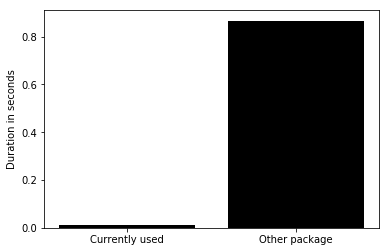

In [4]:
from lib.segmentation import segmentation_adjacency
from skimage.future.graph import RAG

t_current = time.process_time()
segmentation_adjacency(segmentation)
t_current = time.process_time() - t_current

t_other = time.process_time()
RAG(segmentation)
t_other = time.process_time() - t_other

plot_durations(t_current, t_other)

## Form Feature Extraction

Speed comparison of the feature extraction of segments between the currently used version and the version in [`skimage`](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops).

Currently used version: 0.05068s
Version of other package: 0.14397s
=> 184.11% better performance


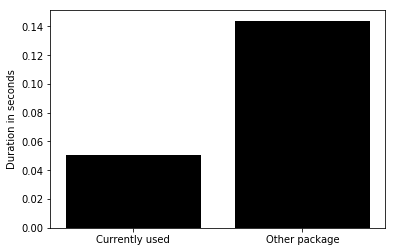

In [5]:
from lib.segmentation import FormFeatureExtraction
from skimage.measure import regionprops

t_current = time.process_time()
FormFeatureExtraction(segmentation).get_features()
t_current = time.process_time() - t_current

t_other = time.process_time()
props = regionprops(segmentation + 1)
features = []
for prop in props:
    prop['area']
    prop['bbox']
    prop['local_centroid']
    prop['eccentricity']
    prop['equivalent_diameter']
    prop['extent']
    prop['moments_hu']
    prop['inertia_tensor']
    prop['inertia_tensor_eigvals']
    prop['major_axis_length']
    prop['minor_axis_length']
    prop['moments_central']
    prop['moments_normalized']
    prop['orientation']
t_other = time.process_time() - t_other

plot_durations(t_current, t_other)

## Coarsening

Speed comparison of the coarsening algorithm between the currently used version and the version used in [`cnn_graph`](https://github.com/mdeff/cnn_graph).

Currently used version: 0.03352s
Version of other package: 0.08708s
=> 159.81% better performance


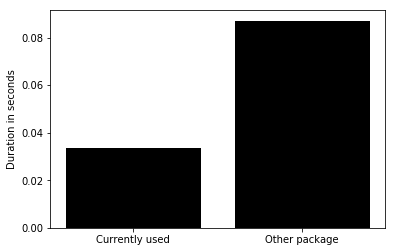

In [6]:
from lib.segmentation import segmentation_adjacency
from lib.graph import coarsen_adj

import os
import imp
import requests

def import_cdn(uri):
    name = os.path.basename(uri).lower().rstrip('.py')

    r = requests.get(uri)
    r.raise_for_status()

    codeobj = compile(r.content, uri, 'exec')
    module = imp.new_module(name)
    exec (codeobj, module.__dict__)
    return module

# Load the cnn_graph coarsen script.
cnn_graph = import_cdn('https://raw.githubusercontent.com/mdeff/cnn_graph/master/lib/coarsening.py')

adj, points, mass = segmentation_adjacency(segmentation)

t_current = time.process_time()
coarsen_adj(adj, points, mass, levels=4)
t_current = time.process_time() - t_current

# Run the coarsen script without slow prints.
t_other = time.process_time()
graphs, parents = cnn_graph.metis(adj, levels=4)
perms = cnn_graph.compute_perm(parents)

for i, A in enumerate(graphs):
    M, M = A.shape

    A = A.tocoo()
    A.setdiag(0)

    if i < 4:
        A = cnn_graph.perm_adjacency(A, perms[i])

    A = A.tocsr()
    A.eliminate_zeros()
    graphs[i] = A
t_other = time.process_time() - t_other

plot_durations(t_current, t_other)